<a href="https://colab.research.google.com/github/Shada97/Semantic-segmentation-using-U-Net/blob/main/Segmentation_BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step1**

In [ ]:
import os
import glob
import json
import numpy as np
import cv2


from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

In [ ]:
#load data
train_path='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/'
test_path="/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/"
valid_path='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/'

In [ ]:
#load image
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

In [ ]:
#annotation
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))

In [ ]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

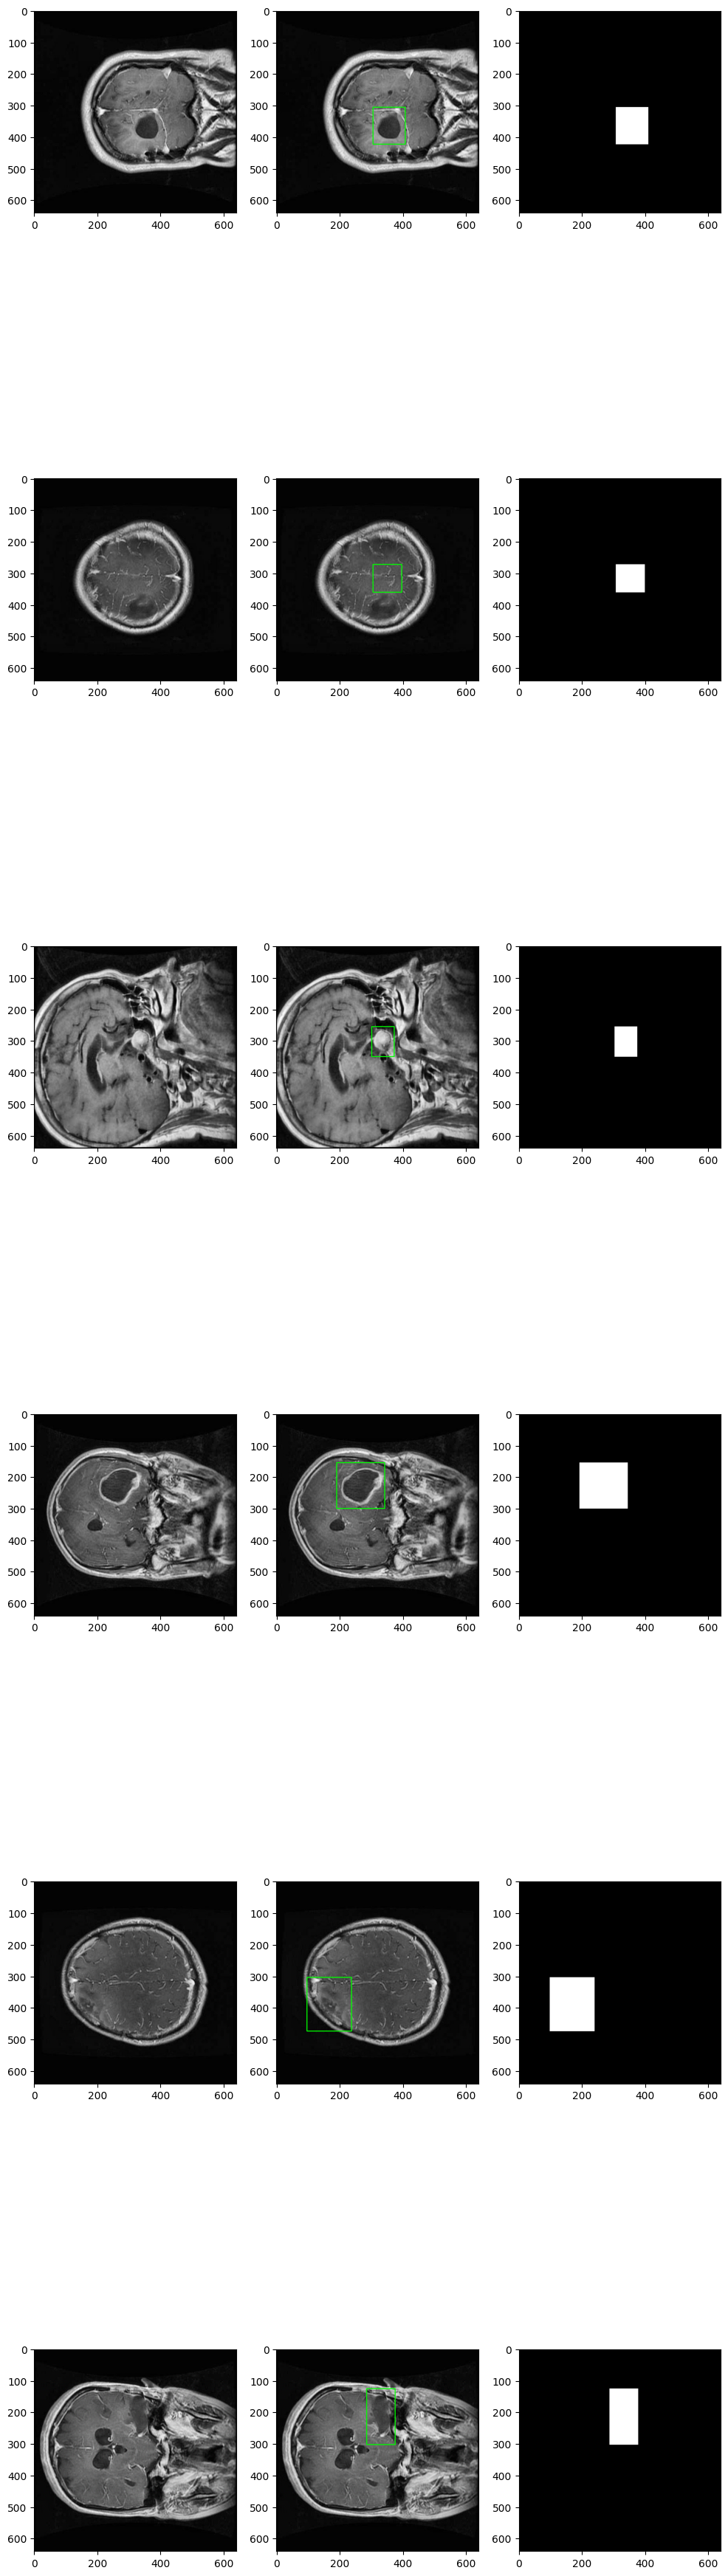

In [ ]:
def visualize_random_images(n=6): # select n random images

  # use cv and plt to show these images
  indices = np.random.randint(0, len(train_annotation['images']), size=n)

    #Image and Annotation Retrieval:
  images =[train_annotation['images'][i] for i in indices ]
  annotations = [train_annotation['annotations'][i] for i in indices ]

  j=1
  plt.figure(figsize=(12, 4 * 2 * n))
  for img,ann in zip(images,annotations):

    plt.subplot(n,3,j)
    j+=1
    image = cv2.imread(train_path + img['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # create masked images from annotations
    segmentation = ann['segmentation']
    segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2) #convert 1D into 2D

    cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

    plt.subplot(n,3,j)
    plt.imshow(image)
    j+=1

    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [segmentation], color=1)
    plt.subplot(n,3,j)
    plt.imshow(mask,cmap='gray')
    j+=1

visualize_random_images()

In [ ]:
import os
import cv2
import numpy as np
from threading import Thread

def create_mask(image_path, mask_path, segmentation):
    """Helper function to create and save mask."""
    image = cv2.imread(image_path)
    segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [segmentation], color=(255, 255, 255))
    cv2.imwrite(mask_path, mask)

def process_masks(annotation_data, image_path, mask_dir, dataset_name):
    """Processes and creates masks for the given dataset."""
    os.makedirs(mask_dir, exist_ok=True)
    total_images = len(annotation_data['images'])
    done = 0

    for img, ann in zip(annotation_data['images'], annotation_data['annotations']):
        img_path = os.path.join(image_path, img['file_name'])
        mask_path = os.path.join(mask_dir, img['file_name'])
        create_mask(img_path, mask_path, ann['segmentation'])
        done += 1
        print(f"{dataset_name} {done} / {total_images}")

def _train_masks():
    print('Generating train masks')
    process_masks(train_annotation, train_path, '/kaggle/working/train_masks/', 'Train')

def _test_masks():
    print('Generating test masks')
    process_masks(test_annotation, test_path, '/kaggle/working/test_masks/', 'Test')

def _val_masks():
    print('Generating validation masks')
    process_masks(valid_annotation, valid_path, '/kaggle/working/val_masks/', 'Validation')

def make_masks():
    threads = [
        Thread(target=_train_masks),
        Thread(target=_test_masks),
        Thread(target=_val_masks)
    ]

    for t in threads:
        t.start()

    for t in threads:
        t.join()

    print('Mask generation complete')

make_masks()


Generating train masks
Generating test masks
Generating validation masks
Validation 1 / 429
Test 1 / 215
Train 1 / 1502
Validation 2 / 429
Train 2 / 1502
Test 2 / 215
Validation 3 / 429
Train 3 / 1502
Test 3 / 215
Test 4 / 215
Validation 4 / 429
Train 4 / 1502
Test 5 / 215
Validation 5 / 429
Train 5 / 1502
Test 6 / 215
Validation 6 / 429
Train 6 / 1502
Test 7 / 215
Train 7 / 1502
Validation 7 / 429
Test 8 / 215
Train 8 / 1502
Validation 8 / 429
Test 9 / 215
Train 9 / 1502
Test 10 / 215
Train 10 / 1502
Validation 9 / 429
Test 11 / 215
Train 11 / 1502
Validation 10 / 429
Test 12 / 215
Train 12 / 1502
Validation 11 / 429
Test 13 / 215
Train 13 / 1502
Test 14 / 215
Validation 12 / 429
Train 14 / 1502
Validation 13 / 429
Test 15 / 215
Train 15 / 1502
Test 16 / 215
Validation 14 / 429
Test 17 / 215
Validation 15 / 429
Train 16 / 1502
Test 18 / 215
Validation 16 / 429
Train 17 / 1502
Test 19 / 215
Validation 17 / 429
Train 18 / 1502
Test 20 / 215
Validation 18 / 429
Train 19 / 1502
Test 21 / 

In [ ]:
#split data

def load_images_and_masks(annotation_data, image_path, mask_dir, target_size=(128, 128)):
    """
    Helper function to load and resize images and corresponding masks.
    """
    # Load and resize images
    X_data = [cv2.resize(cv2.imread(image_path + image['file_name']), target_size) for image in annotation_data['images']]

    # Load and resize masks (grayscale)
    y_data = [cv2.resize(cv2.imread(mask_dir + image['file_name'], cv2.IMREAD_GRAYSCALE), target_size) for image in annotation_data['images']]

    # Convert lists to numpy arrays
    X_data = np.array(X_data)
    y_data = np.expand_dims(np.array(y_data), axis=-1)  # Expand dimensions for compatibility

    # Normalize images and masks
    X_data = X_data.astype('float32') / 255.0
    y_data = y_data.astype('float32') / 255.0
    y_data = (y_data > 0.5).astype(np.float32)  # Binarize masks

    return X_data, y_data

def load_data():
    """
    Loads and processes the training and validation datasets.
    """
    target_size = (128, 128)

    # Directories for train and validation masks
    train_mask_dir = '/kaggle/working/train_masks/'
    val_mask_dir = '/kaggle/working/val_masks/'

    # Load train data
    X_train, y_train = load_images_and_masks(train_annotation, train_path, train_mask_dir, target_size)

    # Load validation data
    X_val, y_val = load_images_and_masks(valid_annotation, valid_path, val_mask_dir, target_size)

    return X_train, y_train, X_val, y_val

def load_test_data():
    """
    Loads and processes the test dataset.
    """
    target_size = (128, 128)
    test_mask_dir = '/kaggle/working/test_masks/'

    # Load test data
    X_test, y_test = load_images_and_masks(test_annotation, test_path, test_mask_dir, target_size)

    return X_test, y_test


In [ ]:
X_train,y_train,X_val,y_val = load_data()

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

**U-Net model**

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=["accuracy"])

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=5)



callbacks_list = [earlystop]

unet_model.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val),callbacks=callbacks_list)

Epoch 1/50


I0000 00:00:1726686154.241998     116 service.cc:145] XLA service 0x7b4970002c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726686154.242077     116 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726686154.242085     116 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726686217.165301     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8997 - loss: 0.5729 - val_accuracy: 0.9627 - val_loss: 0.1469
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.9624 - loss: 0.1176 - val_accuracy: 0.9627 - val_loss: 0.1132
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.9626 - loss: 0.1097 - val_accuracy: 0.9627 - val_loss: 0.1194
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.9636 - loss: 0.1098 - val_accuracy: 0.9627 - val_loss: 0.1252
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.9629 - loss: 0.1090 - val_accuracy: 0.9627 - val_loss: 0.1102
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.9639 - loss: 0.1031 - val_accuracy: 0.9627 - val_loss: 0.1043
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.9625 - loss: 0.1056 - val_accuracy: 0.9627 - val_loss: 0.1091
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 436ms/step - accuracy: 0.9631 - loss: 0.1043 - val_accuracy: 0.9627 

In [ ]:
#PREDICTION
def predict(image_path, model, threshold=0.5):

    # Read and preprocess the image
    image = cv2.imread(image_path)
    print("Original Image Shape:", image.shape)

    # Resize the image to match model's expected sizing
    resized_image = cv2.resize(image, (128, 128))
    print("Resized Image Shape:", resized_image.shape)

    # Expand dimensions to match the batch size used by the model
    input_image = np.expand_dims(resized_image, axis=0)

    # Preprocess input (normalize to [0, 1] range)
    input_image = input_image.astype('float32') / 255.0

    # Perform prediction
    pred_mask = model.predict(input_image)

    # Apply threshold to prediction mask
    pred_mask[pred_mask >= threshold] = 1  # set values >= threshold to 1 (foreground)
    pred_mask[pred_mask < threshold] = 0   # set values < threshold to 0 (background)

    # If your model outputs probabilities, you might need to squeeze the mask
    pred_mask = np.squeeze(pred_mask, axis=0)

    # Count number of pixels where mask is 1 (foreground)
    num_pixels = np.count_nonzero(pred_mask)
    print("shape mask",pred_mask.shape)
    return pred_mask

Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
shape mask (128, 128, 1)
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 1

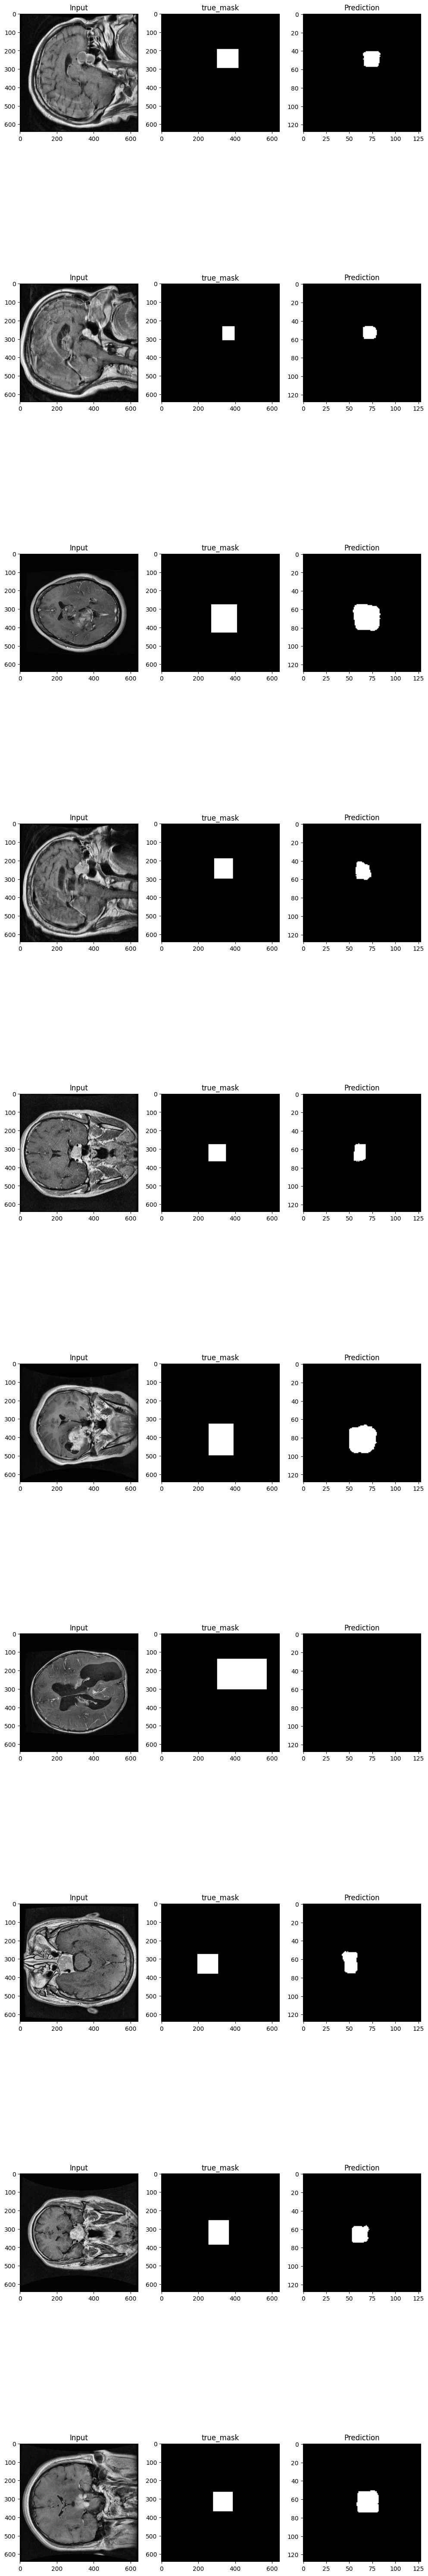

In [ ]:

#Show Result

import matplotlib.pyplot as plt
def test_random_images(n=10):
  # select n random images
  # use cv and plt to show these images
    test_mask_dir = '/kaggle/working/test_masks/'

    indices = np.random.randint(0, len(test_annotation['images']), size=n)

    images =[test_annotation['images'][i] for i in indices ]

    annotations = [test_annotation['annotations'][i] for i in indices ]
    j=1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img,ann in zip(images,annotations):
        plt.subplot(n,3,j)
        j+=1
        image = cv2.imread(test_path + img['file_name'])

        plt.imshow(image)
        plt.title("Input")
        mask = predict(test_path + img['file_name'],unet_model)

        result_image = np.zeros((128, 128,1), dtype=np.uint8)
        result_image[mask == 1] = 255

        true_mask = cv2.imread(test_mask_dir + img['file_name'])
        plt.subplot(n,3,j)
        j+=1
        plt.imshow(true_mask)
        plt.title("true_mask")

        plt.subplot(n,3,j)
        j+=1
        plt.imshow(result_image,cmap='gray')
        plt.title("Prediction")

test_random_images()

